In [ ]:
import os
import csv
import numpy as np
import pandas as pd
from bokeh.models import LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar, HoverTool, ColumnDataSource
from bokeh.plotting import figure, output_file, save, show
from math import pi
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, matthews_corrcoef
import matplotlib
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import umap

In [24]:
with open('data/odf-data-2019-06-13-12-28-37/level-4/cohort-vocab.csv') as f:
    rd = csv.reader(f)
    next(rd)
    feat = set()
    idx_to_vc = {}
    for r in rd:
        idx_to_vc[r[1]] = r[0]
        tmp_sp = r[0].split('::')
        feat.add('::'.join(tmp_sp[:len(tmp_sp)-1]))
    feat = sorted(list(feat))
print(feat)

['ados::comparison_score', 'ados::rrb_tot', 'ados::sa_tot', 'gmds::GQ', 'gmds::q_A', 'gmds::q_B', 'gmds::q_C', 'gmds::q_D', 'gmds::q_E', 'gmds::q_F', 'psi-sf::Madre::raw_ts', 'psi-sf::Padre::raw_ts', 'srs::caretaker::raw_tot', 'vineland::caretaker::standard_ABC', 'vineland::caretaker::standard_CD', 'vineland::caretaker::standard_DLSD', 'vineland::caretaker::standard_MSD', 'vineland::caretaker::standard_SD', 'wechsler::FS']


In [25]:
with open('data/odf-data-2019-06-13-12-28-37/level-4/cohort-behr.csv') as f:
    rd = csv.reader(f)
    next(rd)
    behr = {}
    for r in rd:
        behr.setdefault(r[0], list()).append([float(r[1])] + sorted([idx_to_vc[t] for t in r[2::]]))
        
tehr = {k: {'F1': {},
            'F2': {},
            'F3': {},
            'F4': {},
            'F5': {}} for k in behr.keys()}

for id_subj, vect in behr.items():
    for el in vect:
        if float(el[0]) > 0 and float(el[0]) <= 2.5:
            for e in el[1::]:
                tehr[id_subj]['F1'].setdefault('::'.join(e.split('::')[:len(e.split('::'))-1]), 
                                               list()).append(int(e.split('::')[-1]))
        elif float(el[0]) > 2.5 and float(el[0]) <= 6.0:
            for e in el[1::]:
                tehr[id_subj]['F2'].setdefault('::'.join(e.split('::')[:len(e.split('::'))-1]), 
                                                   list()).append(int(e.split('::')[-1]))
        elif float(el[0]) > 6.0 and float(el[0]) <= 13.0:
            for e in el[1::]:
                tehr[id_subj]['F3'].setdefault('::'.join(e.split('::')[:len(e.split('::'))-1]), 
                                                   list()).append(int(e.split('::')[-1]))
        elif float(el[0]) > 13.0 and float(el[0]) < 17.0:
            for e in el[1::]:
                tehr[id_subj]['F4'].setdefault('::'.join(e.split('::')[:len(e.split('::'))-1]), 
                                                   list()).append(int(e.split('::')[-1]))
        else:
            for e in el[1::]:
                tehr[id_subj]['F5'].setdefault('::'.join(e.split('::')[:len(e.split('::'))-1]), 
                                                   list()).append(int(e.split('::')[-1]))
            
print(tehr['lab0993'])

{'F1': {'ados::rrb_tot': [4], 'ados::sa_tot': [8], 'gmds::GQ': [95], 'gmds::q_A': [111], 'gmds::q_B': [93], 'gmds::q_C': [65], 'gmds::q_D': [96], 'gmds::q_E': [113], 'psi-sf::Madre::raw_ts': [64], 'psi-sf::Padre::raw_ts': [91]}, 'F2': {'gmds::GQ': [91, 93, 90], 'gmds::q_A': [106, 100, 88], 'gmds::q_B': [81, 97, 82], 'gmds::q_C': [70, 83, 97], 'gmds::q_D': [86, 97, 76], 'gmds::q_E': [131, 97, 88], 'gmds::q_F': [73, 91, 106], 'ados::comparison_score': [4, 8], 'ados::rrb_tot': [1, 6], 'ados::sa_tot': [7, 11], 'vineland::caretaker::standard_ABC': [71, 77], 'vineland::caretaker::standard_CD': [67, 83], 'vineland::caretaker::standard_DLSD': [87, 89], 'vineland::caretaker::standard_MSD': [75, 84], 'vineland::caretaker::standard_SD': [70, 65], 'srs::caretaker::raw_tot': [75, 70]}, 'F3': {}, 'F4': {}, 'F5': {}}


In [26]:
df_dict = {k: {} for k in tehr.keys()}
for id_lab, tim in tehr.items():
    for t in tim:
        for f in feat:
            try: 
                df_dict[id_lab].setdefault(t, list()).extend([np.mean(tehr[id_lab][t][f])])
            except KeyError:
                df_dict[id_lab].setdefault(t, list()).extend([np.nan])

df_list = []
df_list_wide = []
for id_subj, tim in df_dict.items():
    tmp_l = []
    feat_wide = []
    for t, el in tim.items():
        for f in feat:
            feat_wide.append('::'.join([t, f]))
        df_list.append([id_subj, t] + [e for e in el])
        tmp_l.extend([e for e in el])
    df_list_wide.append([id_subj] + tmp_l)
df = pd.DataFrame(df_list, columns=['id_subj', 'time'] + feat)

df_wide = pd.DataFrame(df_list_wide, columns=['id_subj'] + feat_wide)
df_wide = df_wide.set_index('id_subj')
df_wide_fi = df_wide.fillna(df_wide.mean()).dropna(axis=1)

scaler = StandardScaler()

df_wide_scaled = scaler.fit_transform(df_wide_fi)

df_wide_scaled = pd.DataFrame(df_wide_scaled, columns=list(df_wide_fi.columns))
df_wide_scaled['id_subj'] = df_wide.index
df_wide_scaled = df_wide_scaled.set_index('id_subj')
print(df_wide_scaled.loc['lab0993'])

F1::ados::comparison_score                3.749705e-15
F1::ados::rrb_tot                         3.432686e+00
F1::ados::sa_tot                         -4.044870e+00
F1::gmds::GQ                              5.424879e+00
F1::gmds::q_A                             5.829349e+00
F1::gmds::q_B                             5.183447e+00
F1::gmds::q_C                             1.608009e+00
F1::gmds::q_D                             4.765990e+00
F1::gmds::q_E                             3.640282e+00
F1::gmds::q_F                             0.000000e+00
F1::psi-sf::Madre::raw_ts                -1.712384e+00
F1::psi-sf::Padre::raw_ts                 4.562373e+00
F1::srs::caretaker::raw_tot              -1.218689e-14
F1::vineland::caretaker::standard_ABC     0.000000e+00
F1::vineland::caretaker::standard_CD      0.000000e+00
F1::vineland::caretaker::standard_DLSD    0.000000e+00
F1::vineland::caretaker::standard_MSD     2.275911e-14
F1::vineland::caretaker::standard_SD      0.000000e+00
F2::ados::

In [35]:
df_wide_scaled = pd.DataFrame(df_wide_scaled.stack(), columns=['value_sc']).reset_index()
df_wide_scaled['value'] = pd.DataFrame(df_wide_fi.stack(), 
                                       columns=['value']).reset_index()['value']

In [30]:
print(df_wide_fi)

         F1::ados::comparison_score  F1::ados::rrb_tot  F1::ados::sa_tot  \
id_subj                                                                    
lab1439                    5.666667           3.066667         12.533333   
lab1060                    5.666667           3.066667         12.533333   
lab1365                    5.666667           3.066667         12.533333   
lab1191                    5.666667           3.066667         12.533333   
lab0993                    5.666667           4.000000          8.000000   
lab1224                    5.000000           3.000000         11.000000   
lab1222                    5.666667           3.066667         12.533333   
lab1218                    5.666667           3.000000         15.000000   
lab1217                    5.666667           3.066667         12.533333   
lab0879                    5.666667           3.066667         12.533333   
lab1240                    5.666667           3.066667         12.533333   
lab0852     

In [6]:
colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41",
          "#550b1d"]
mapper = LinearColorMapper(palette=colors,
                           low=df_wide_scaled.value_sc.min(),
                           high=df_wide_scaled.value_sc.max())

id_subj = sorted(list(set(df_wide_scaled['id_subj'])))
feat_F = sorted(list(set(df_wide_scaled['level_1'])))

p = figure(title="Scores level {0}".format(4),
           x_range=feat_F, y_range=id_subj, 
           x_axis_location="above", plot_width=800, plot_height=1800,
           toolbar_location='below')

TOOLTIPS = [('id_subj', '@id_subj'),
            ('feat', '@level_1'),
            ('value', '@value')]

p.add_tools(HoverTool(tooltips=TOOLTIPS))

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.xaxis.major_label_text_font_size = "7pt"
p.yaxis.major_label_text_font_size = "7pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 2

p.rect(x="level_1", y="id_subj", width=1, height=1,
       source=df_wide_scaled,
       fill_color={'field': 'value_sc', 
                   'transform': mapper},
       line_color=None)

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="8pt",
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%d.2"),
                     label_standoff=6, border_line_color=None, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)

In [7]:
dt = scaler.fit_transform(df_wide_fi)
print(dt.shape)

(202, 78)


In [18]:
# Hierarchical clustering

n_clu = 15
dt = scaler.fit_transform(df_wide_fi)

n_cl_selected = []
for it in range(100):
    idx = np.random.randint(0, dt.shape[0], int(dt.shape[0]*0.7))
    tmp_dt = [dt[i] for i in idx]
    best_silh = 0
    for n in range(2, n_clu):
        hclu = AgglomerativeClustering(n_clusters=n, linkage='ward')
        lab_cl = hclu.fit_predict(tmp_dt)
        tmp_silh = silhouette_score(tmp_dt, lab_cl)
        if tmp_silh > best_silh:
            best_silh = tmp_silh
            best_lab_cl = lab_cl
            best_n_clu = n
    print("(*) Iter {0} -- N clusters {1}".format(it, best_n_clu))
    n_cl_selected.append(best_n_clu)
unique, counts = np.unique(n_cl_selected, return_counts=True)
print("Counts of N clusters:")
print("N clusters -- Count")
for a, b in dict(zip(unique, counts)).items():
    print(a, b)
print("\nBest N cluster:{0}".format(unique[np.argmax(counts)]))

best_n_clu = unique[np.argmax(counts)]
hclu = AgglomerativeClustering(n_clusters=best_n_clu, linkage='ward')
lab_cl = hclu.fit_predict(dt)
silh = silhouette_score(dt, lab_cl)
print('(*) Number of clusters %d -- Silhouette score %.2f' % (best_n_clu, silh))

num_count = np.unique(lab_cl, return_counts=True)[1]
for idx, nc in enumerate(num_count):
    print("Cluster {0} -- Numerosity {1}".format(idx, nc))
print('\n')
print('\n')

(*) Iter 0 -- N clusters 2
(*) Iter 1 -- N clusters 2
(*) Iter 2 -- N clusters 2
(*) Iter 3 -- N clusters 2
(*) Iter 4 -- N clusters 2


(*) Iter 5 -- N clusters 2
(*) Iter 6 -- N clusters 3
(*) Iter 7 -- N clusters 2
(*) Iter 8 -- N clusters 2
(*) Iter 9 -- N clusters 2


(*) Iter 10 -- N clusters 2
(*) Iter 11 -- N clusters 4
(*) Iter 12 -- N clusters 2
(*) Iter 13 -- N clusters 2
(*) Iter 14 -- N clusters 11


(*) Iter 15 -- N clusters 2
(*) Iter 16 -- N clusters 2
(*) Iter 17 -- N clusters 2
(*) Iter 18 -- N clusters 2
(*) Iter 19 -- N clusters 2


(*) Iter 20 -- N clusters 2
(*) Iter 21 -- N clusters 3
(*) Iter 22 -- N clusters 4
(*) Iter 23 -- N clusters 2
(*) Iter 24 -- N clusters 2


(*) Iter 25 -- N clusters 2
(*) Iter 26 -- N clusters 2
(*) Iter 27 -- N clusters 2
(*) Iter 28 -- N clusters 2
(*) Iter 29 -- N clusters 2


(*) Iter 30 -- N clusters 4
(*) Iter 31 -- N clusters 2
(*) Iter 32 -- N clusters 4
(*) Iter 33 -- N clusters 2
(*) Iter 34 -- N clusters 2


(*) Iter 35 -- N clusters 2
(*) Iter 36 -- N clusters 2
(*) Iter 37 -- N clusters 2
(*) Iter 38 -- N clusters 2
(*) Iter 39 -- N clusters 2


(*) Iter 40 -- N clusters 2
(*) Iter 41 -- N clusters 2
(*) Iter 42 -- N clusters 4
(*) Iter 43 -- N clusters 2
(*) Iter 44 -- N clusters 2


(*) Iter 45 -- N clusters 2
(*) Iter 46 -- N clusters 2
(*) Iter 47 -- N clusters 2
(*) Iter 48 -- N clusters 2
(*) Iter 49 -- N clusters 4


(*) Iter 50 -- N clusters 5
(*) Iter 51 -- N clusters 3
(*) Iter 52 -- N clusters 2
(*) Iter 53 -- N clusters 2
(*) Iter 54 -- N clusters 2


(*) Iter 55 -- N clusters 2
(*) Iter 56 -- N clusters 2
(*) Iter 57 -- N clusters 2
(*) Iter 58 -- N clusters 2
(*) Iter 59 -- N clusters 2


(*) Iter 60 -- N clusters 2
(*) Iter 61 -- N clusters 2
(*) Iter 62 -- N clusters 4
(*) Iter 63 -- N clusters 9
(*) Iter 64 -- N clusters 2


(*) Iter 65 -- N clusters 3
(*) Iter 66 -- N clusters 2
(*) Iter 67 -- N clusters 2
(*) Iter 68 -- N clusters 2
(*) Iter 69 -- N clusters 3


(*) Iter 70 -- N clusters 11
(*) Iter 71 -- N clusters 2
(*) Iter 72 -- N clusters 7
(*) Iter 73 -- N clusters 2
(*) Iter 74 -- N clusters 2


(*) Iter 75 -- N clusters 2
(*) Iter 76 -- N clusters 2
(*) Iter 77 -- N clusters 2
(*) Iter 78 -- N clusters 2
(*) Iter 79 -- N clusters 2


(*) Iter 80 -- N clusters 11
(*) Iter 81 -- N clusters 2
(*) Iter 82 -- N clusters 2
(*) Iter 83 -- N clusters 3
(*) Iter 84 -- N clusters 3


(*) Iter 85 -- N clusters 4
(*) Iter 86 -- N clusters 2
(*) Iter 87 -- N clusters 14
(*) Iter 88 -- N clusters 2
(*) Iter 89 -- N clusters 2


(*) Iter 90 -- N clusters 2
(*) Iter 91 -- N clusters 3
(*) Iter 92 -- N clusters 2
(*) Iter 93 -- N clusters 2
(*) Iter 94 -- N clusters 3


(*) Iter 95 -- N clusters 2
(*) Iter 96 -- N clusters 3
(*) Iter 97 -- N clusters 5
(*) Iter 98 -- N clusters 2
(*) Iter 99 -- N clusters 2
Counts of N clusters:
N clusters -- Count
2 74
3 10
4 8
5 2
7 1
9 1
11 3
14 1

Best N cluster:2
(*) Number of clusters 2 -- Silhouette score 0.67
Cluster 0 -- Numerosity 201
Cluster 1 -- Numerosity 1






In [19]:
col_dict = matplotlib.colors.CSS4_COLORS
c_out = ['bisque', 'mintcream', 'cornsilk', 'lavenderblush', 'aliceblue', 'antiquewhite', 'aqua', 
         'aquamarine', 'azure', 'beige', 'powderblue', 'floralwhite', 'ghostwhite', 'lightcoral', 
         'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 
         'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightslategrey', 
         'lightsteelblue', 'lightyellow', 'linen', 'palegoldenrod', 'palegreen', 'paleturquoise', 
         'palevioletred', 'papayawhip', 'peachpuff', 'mistyrose', 'lemonchiffon', 'lightblue',
         'seashell', 'white', 'blanchedalmond', 'oldlace', 'moccasin', 'snow', 'darkgray', 
         'ivory', 'whitesmoke']


In [20]:
def single_plot(data, labels, colors, leg_labels=None):
    plt.figure(figsize=(20, 10))
    for cl in set(labels):
        x = [d[0] for j, d in enumerate(data) if labels[j] == cl]
        y = [d[1] for j, d in enumerate(data) if labels[j] == cl]
        cols = [c for j, c in enumerate(colors) if labels[j] == cl]
        plt.xticks([])
        plt.yticks([])
        plt.scatter(x, y, c=cols, label=cl, s=20)
    if leg_labels is not None:
        plt.legend(loc=3, labels=leg_labels, markerscale=4, fontsize=20)
    else:
        plt.legend(loc=3, markerscale=4, fontsize=20)
    plt.show()
    # plt.savefig(os.path.join(outdir, 'tfidf-plot.png'))

{0, 1}


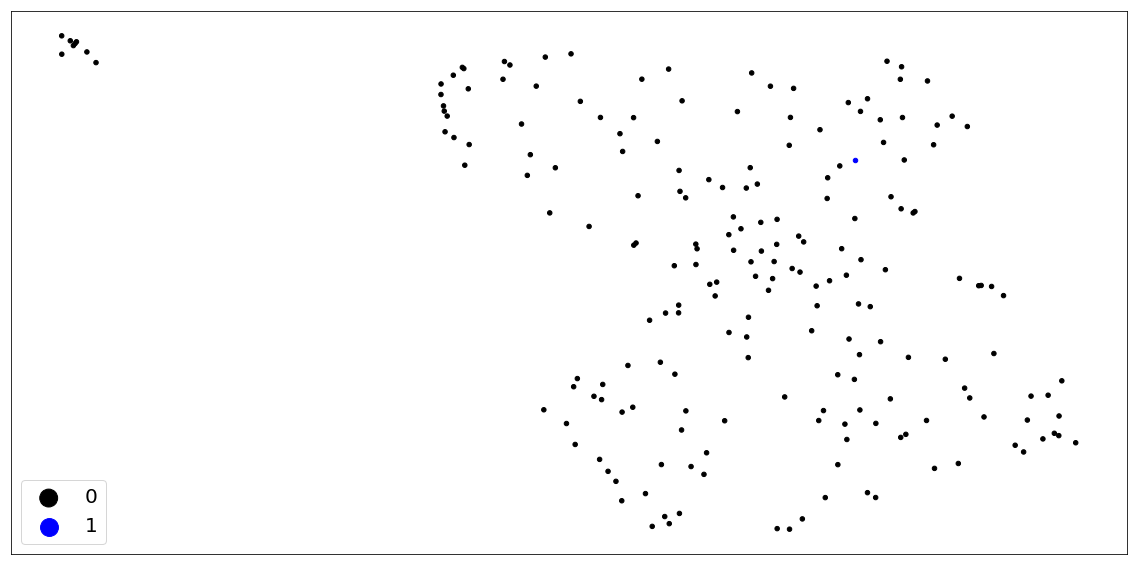

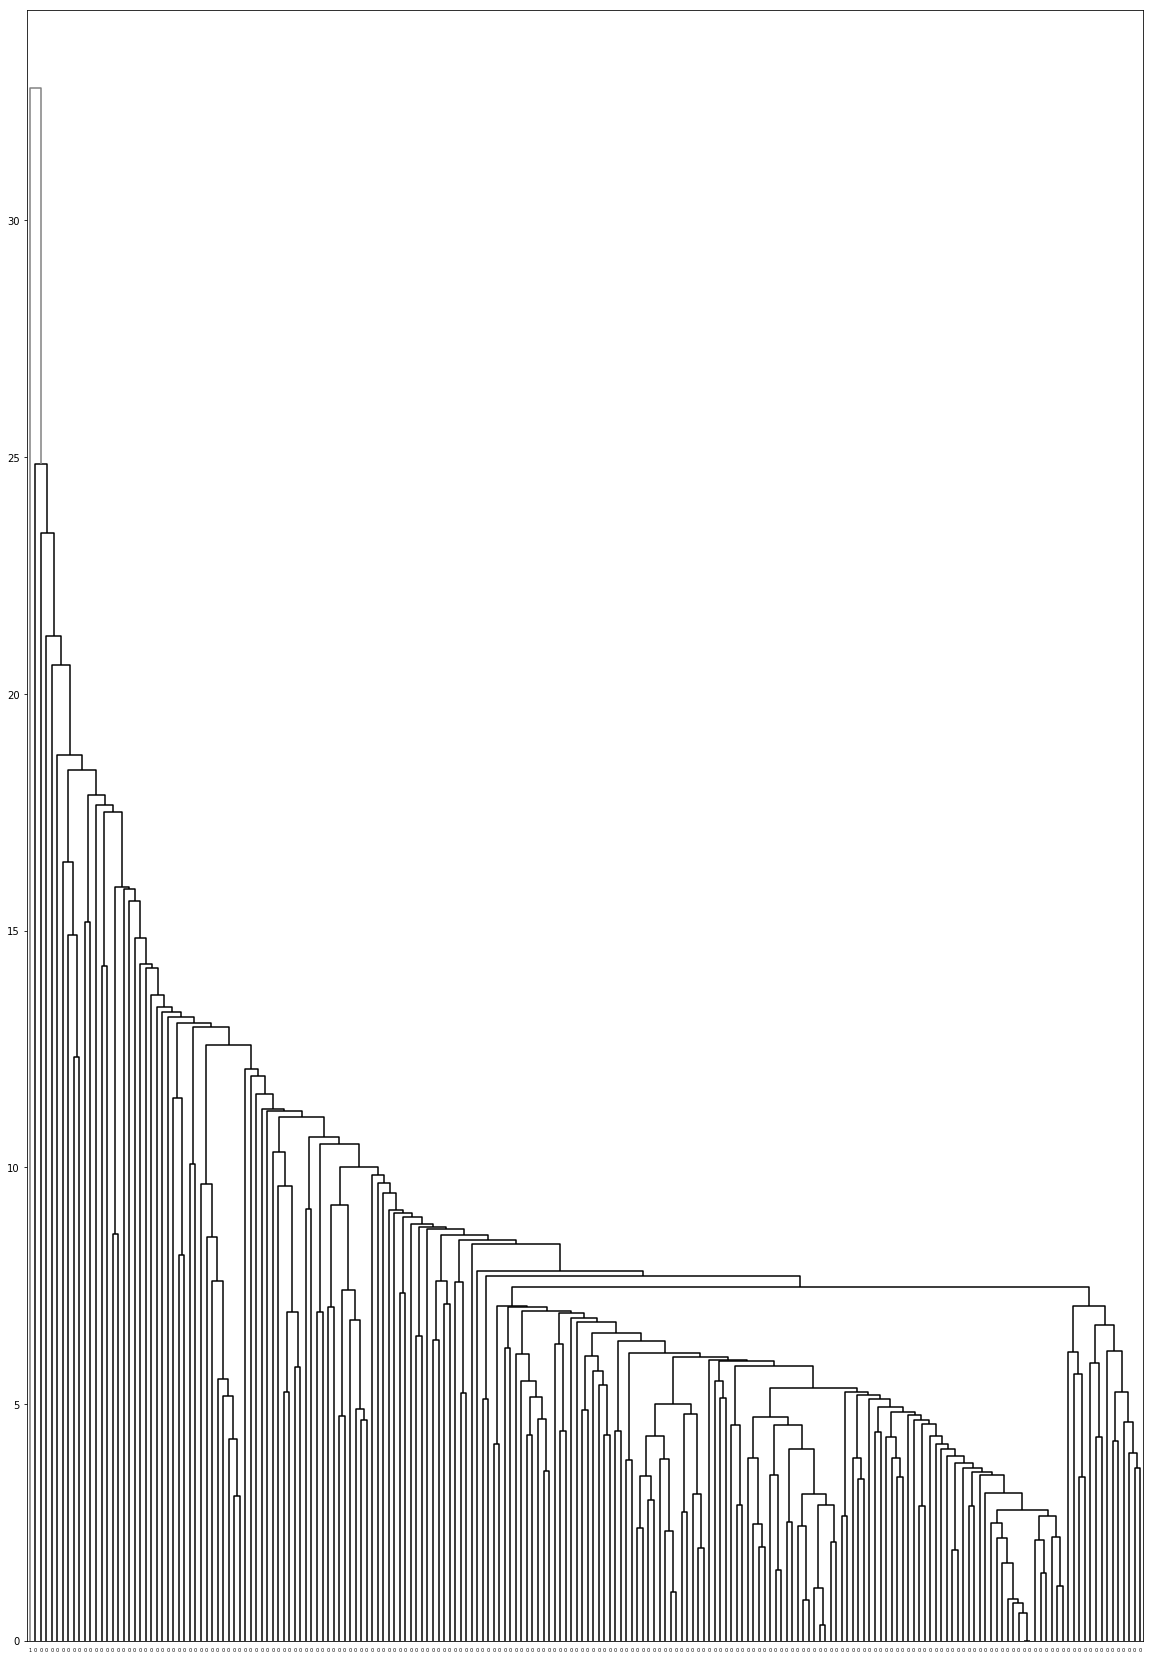

In [21]:
colormap = [c for c in col_dict if c not in c_out]
colormap_rid = [colormap[cl] for cl in sorted(list(set(lab_cl)))]
colors_en = [colormap_rid[v] for v in lab_cl]
umap_mtx = umap.UMAP(random_state=42).fit_transform(dt)
print(set(lab_cl))
single_plot(umap_mtx, lab_cl, colors_en)

linked = linkage(dt, 'average')
    # Color mapping
dflt_col = "#808080"  # Unclustered gray
    # * rows in Z correspond to "inverted U" links that connect clusters
    # * rows are ordered by increasing distance
    # * if the colors of the connected clusters match, use that color for link
link_cols = {}
for i, i12 in enumerate(linked[:, :2].astype(int)):
    c1, c2 = (link_cols[x] if x > len(linked) else colormap_rid[lab_cl[x]]
              for x in i12)
    link_cols[i + 1 + len(linked)] = c1 if c1 == c2 else dflt_col

plt.figure(figsize=(20, 30))
    # Dendrogram
dendrogram(Z=linked, labels=lab_cl, color_threshold=None,
           leaf_font_size=5, leaf_rotation=0, link_color_func=lambda x: link_cols[x])
plt.show()